In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf #pip install
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from sklearn.model_selection import cross_val_predict
import warnings
from scipy import stats
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import pandas_ta as ta #pip install
from sklearn.tree import DecisionTreeRegressor
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dateutil.relativedelta import *
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor #pip install
from random import randint, uniform
import plotly.graph_objects as go

In [2]:
class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='Date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='Date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits 
    
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate=20):
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

In [3]:
df_o=pd.read_csv('data_updated/open.csv')
df_c=pd.read_csv('data_updated/close.csv')
df_adj=pd.read_csv('data_updated/adj_close.csv')
df_h=pd.read_csv('data_updated/high.csv')
df_l=pd.read_csv('data_updated/low.csv')
df_v=pd.read_csv('data_updated/volume.csv')
#df_s=pd.read_csv('data_updated/total.csv')

In [4]:
df_adj['Date']=pd.to_datetime(df_adj['Date'])
df_v['Date']=pd.to_datetime(df_v['Date'])
df_o['Date']=pd.to_datetime(df_o['Date'])
df_c['Date']=pd.to_datetime(df_c['Date'])
df_h['Date']=pd.to_datetime(df_h['Date'])
df_l['Date']=pd.to_datetime(df_l['Date'])
#df_s['Date']=pd.to_datetime(df_s['Date'])

In [5]:
df_adj.set_index(['Date'], inplace=True)
df_v.set_index(['Date'], inplace=True)
df_h.set_index(['Date'], inplace=True)
df_l.set_index(['Date'], inplace=True)
df_c.set_index(['Date'], inplace=True)
df_o.set_index(['Date'], inplace=True)
#df_s.set_index(['Date'], inplace=True)

In [6]:
df_adj=df_adj.melt(ignore_index=False).rename(columns={'variable':'crypto','value':'adj_close'}).reset_index()
df_v=df_v.melt(ignore_index=False).rename(columns={'variable':'crypto','value':'volume'}).reset_index()
df_o=df_o.melt(ignore_index=False).rename(columns={'variable':'crypto','value':'open'}).reset_index()
df_c=df_c.melt(ignore_index=False).rename(columns={'variable':'crypto','value':'close'}).reset_index()
df_h=df_h.melt(ignore_index=False).rename(columns={'variable':'crypto','value':'high'}).reset_index()
df_l=df_l.melt(ignore_index=False).rename(columns={'variable':'crypto','value':'low'}).reset_index()
#df_s=df_s.melt(ignore_index=False).rename(columns={'variable':'crypto','value':'supply'}).reset_index()

In [7]:
df=df_h.merge(df_l).merge(df_c).merge(df_o).merge(df_v).merge(df_adj)

In [8]:
df.sort_values(by='Date', ascending = True, inplace=True)
df.reset_index(inplace=True, drop=True)
#df_s.sort_values(by='Date', ascending = True, inplace=True)
#df_s.reset_index(inplace=True, drop=True)

In [9]:
df['crypto'].unique()
#10 different cryptocurrencies

array(['ADA-USD', 'ETH-USD', 'AXS-USD', 'LINK-USD', 'AVAX-USD',
       'LUNA1-USD', 'MATIC-USD', 'ATOM-USD', 'SOL-USD', 'BTC-USD'],
      dtype=object)

In [10]:
df['crypto']=df.crypto.str.replace('-USD','')
#if we want to drop the -USD and just show the symbol

In [11]:
df.shape

(18260, 8)

In [12]:
df.dropna(inplace=True)
#we're dropping 6,442 rows here but it's for crypto coins that didn't exist yet

In [13]:
df_rindex=df.copy()
#for when we want a numerical index

In [14]:
df_ada=df_rindex.loc[(df['crypto']=='ADA')].reset_index(drop=True)
df_link=df_rindex.loc[(df['crypto']=='LINK')].reset_index(drop=True)
df_eth=df_rindex.loc[(df['crypto']=='ETH')].reset_index(drop=True)
df_atom=df_rindex.loc[(df['crypto']=='ATOM')].reset_index(drop=True)
df_matic=df_rindex.loc[(df['crypto']=='MATIC')].reset_index(drop=True)
df_luna=df_rindex.loc[(df['crypto']=='LUNA1')].reset_index(drop=True)
df_sol=df_rindex.loc[(df['crypto']=='SOL')].reset_index(drop=True)
df_avax=df_rindex.loc[(df['crypto']=='AVAX')].reset_index(drop=True)
df_axs=df_rindex.loc[(df['crypto']=='AXS')].reset_index(drop=True)

In [15]:
#df['year']=df['Date'].dt.year

In [16]:
df.set_index(['Date'], inplace=True)
#For doing specific visualizations like Matplotlib Finance and SARIMAX the date has to be set as the index

# Working with BTC

In [17]:
#creating a df for only BTC
df_btc=df.loc[(df['crypto']=='BTC')]

In [18]:
df_btc.sort_values(by='high', ascending=False)
#to see when I should've sold

,crypto,high,low,close,open,volume,adj_close
Date,,,,,,,
2021-11-10,BTC,68789.625000,63208.113281,64995.230469,66953.335938,4.873083e+10,64995.230469
2021-11-09,BTC,68530.335938,66382.062500,66971.828125,67549.734375,4.235799e+10,66971.828125
2021-11-08,BTC,67673.742188,63344.066406,67566.828125,63344.066406,4.112561e+10,67566.828125
2021-10-20,BTC,66930.390625,63610.675781,65992.835938,64284.585938,4.078896e+10,65992.835938
2021-10-21,BTC,66600.546875,62117.410156,62210.171875,66002.234375,4.590812e+10,62210.171875
...,...,...,...,...,...,...,...
2017-05-14,BTC,1831.420044,1776.619995,1808.910034,1800.859985,4.371960e+08,1808.910034
2017-05-13,BTC,1812.989990,1651.079956,1804.910034,1723.119995,5.796350e+08,1804.910034
2017-05-15,BTC,1812.800049,1708.540039,1738.430054,1808.439941,7.315290e+08,1738.430054


In [19]:
df_nobtc=df.loc[(df['crypto']!='BTC')]
#if we wanted to analyze the crypto coins w/o BTC

In [20]:
avg_df = df.groupby(['crypto'], as_index=False).mean()

<AxesSubplot:xlabel='crypto', ylabel='volume'>

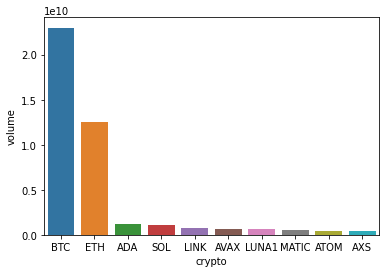

In [21]:
sns.barplot(x='crypto',y='volume',data=avg_df, order=avg_df.sort_values('volume', ascending=False).crypto)

<AxesSubplot:xlabel='crypto', ylabel='high'>

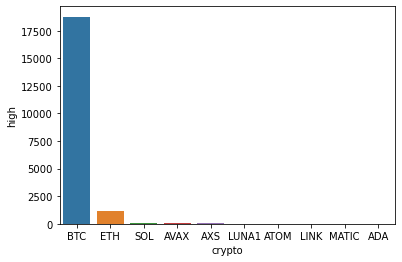

In [22]:
sns.barplot(x='crypto',y='high',data=avg_df, order=avg_df.sort_values('high', ascending=False).crypto)

In [23]:
iday = df_btc.loc['2022-1-31':'2022-4-06',:]

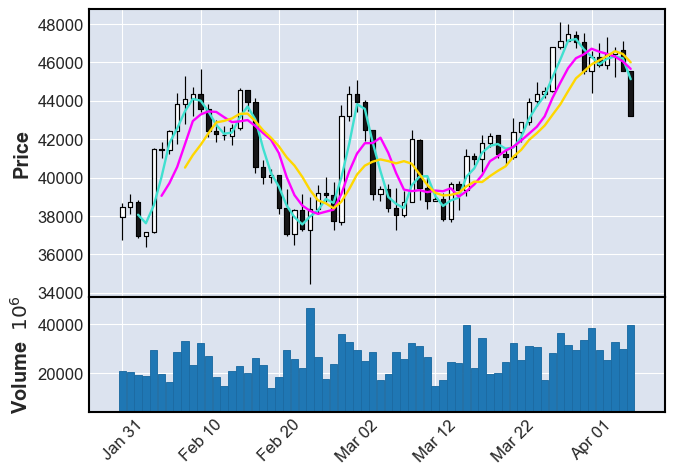

In [24]:
mpf.plot(iday,type='candle',mav=(3,6,9),volume=True)
#moving average 3day, 6day, 9 day

# Relative Strength Index for Bitcoin

In [25]:
df_bcopy=df_btc[['close']]

In [26]:
df_bcopy=df_bcopy.diff(1).rename(columns={'close':'diff'})

In [27]:
df_bcopy['gain'] = df_bcopy['diff'].clip(lower=0).round(2)
df_bcopy['loss'] = df_bcopy['diff'].clip(upper=0).abs().round(2)

In [28]:
window_length=14
df_bcopy['avg_gain'] = df_bcopy['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
df_bcopy['avg_loss'] = df_bcopy['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

In [29]:
for i, row in enumerate(df_bcopy['avg_gain'].iloc[window_length+1:]):
    df_bcopy['avg_gain'].iloc[i + window_length + 1] =\
        (df_bcopy['avg_gain'].iloc[i + window_length] *
         (window_length - 1) +
         df_bcopy['gain'].iloc[i + window_length + 1])\
        / window_length
# Average Losses
for i, row in enumerate(df_bcopy['avg_loss'].iloc[window_length+1:]):
    df_bcopy['avg_loss'].iloc[i + window_length + 1] =\
        (df_bcopy['avg_loss'].iloc[i + window_length] *
         (window_length - 1) +
         df_bcopy['loss'].iloc[i + window_length + 1])\
        / window_length

In [30]:
df_bcopy['rs'] = df_bcopy['avg_gain'] / df_bcopy['avg_loss']

In [31]:
df_bcopy['rsi'] = 100 - (100 / (1.0 + df_bcopy['rs']))

In [32]:
df_btc=pd.concat([df_btc,df_bcopy], axis=1)

# Features for ADA

In [33]:
df_acopy=df_ada[['close']]

In [34]:
df_acopy=df_acopy.diff(1).rename(columns={'close':'diff'})

In [35]:
df_acopy['gain'] = df_acopy['diff'].clip(lower=0).round(2)
df_acopy['loss'] = df_acopy['diff'].clip(upper=0).abs().round(2)

In [36]:
window_length=14
df_acopy['avg_gain'] = df_acopy['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
df_acopy['avg_loss'] = df_acopy['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

In [37]:
for i, row in enumerate(df_acopy['avg_gain'].iloc[window_length+1:]):
    df_acopy['avg_gain'].iloc[i + window_length + 1] =\
        (df_acopy['avg_gain'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['gain'].iloc[i + window_length + 1])\
        / window_length
# Average Losses
for i, row in enumerate(df_acopy['avg_loss'].iloc[window_length+1:]):
    df_acopy['avg_loss'].iloc[i + window_length + 1] =\
        (df_acopy['avg_loss'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['loss'].iloc[i + window_length + 1])\
        / window_length

In [38]:
df_acopy['rs'] = df_acopy['avg_gain'] / df_acopy['avg_loss']

In [39]:
df_acopy['rsi'] = 100 - (100 / (1.0 + df_acopy['rs']))

In [40]:
df_ada=pd.concat([df_ada,df_acopy], axis=1) #RSI for ADA

In [41]:
closing_prices_a = df_ada['close']

bollinger_up, bollinger_down = get_bollinger_bands(closing_prices_a)

In [42]:
sma_a = get_sma(closing_prices_a, 20)

In [43]:
sma_a = pd.DataFrame(data=sma_a).rename(columns={'close':'bollinger'})

In [44]:
df_ada=pd.concat([df_ada,sma_a],axis=1)

In [45]:
exp1 = df_ada['close'].ewm(span=12, adjust=False).mean()
exp2 = df_ada['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s

In [46]:
df_ada['macd'] = df_ada.index.map(macd)
df_ada['macd_sig'] = df_ada.index.map(macd_h)
df_ada['macd_cd'] = df_ada.index.map(macd_s) #Bollinger Bands for ADA

In [47]:
exp1 = df_ada['close'].ewm(span=12, adjust=False).mean()
exp2 = df_ada['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s 

In [48]:
df_ada['macd'] = df_ada.index.map(macd)
df_ada['macd_sig'] = df_ada.index.map(macd_h)
df_ada['macd_cd'] = df_ada.index.map(macd_s) #MACD for ADA

In [49]:
df_ada.ta.stoch(high='high', low='low', k=14, d=3, append=True)
#that's literally it

,STOCHk_14_3_3,STOCHd_14_3_3
13,NaN,NaN
14,NaN,NaN
15,50.847663,NaN
16,61.891704,NaN
17,73.008696,61.916021
...,...,...
1637,32.438020,21.207563
1638,35.786148,28.285136
1639,39.779513,36.001227
1640,21.112731,32.226131


# Features for ETH

In [50]:
df_ecopy=df_eth[['close']]

In [51]:
df_ecopy=df_ecopy.diff(1).rename(columns={'close':'diff'})

In [52]:
df_ecopy['gain'] = df_ecopy['diff'].clip(lower=0).round(2)
df_ecopy['loss'] = df_ecopy['diff'].clip(upper=0).abs().round(2)

In [53]:
window_length=14
df_ecopy['avg_gain'] = df_ecopy['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
df_ecopy['avg_loss'] = df_ecopy['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

In [54]:
for i, row in enumerate(df_ecopy['avg_gain'].iloc[window_length+1:]):
    df_ecopy['avg_gain'].iloc[i + window_length + 1] =\
        (df_ecopy['avg_gain'].iloc[i + window_length] *
         (window_length - 1) +
         df_ecopy['gain'].iloc[i + window_length + 1])\
        / window_length
# Average Losses
for i, row in enumerate(df_ecopy['avg_loss'].iloc[window_length+1:]):
    df_ecopy['avg_loss'].iloc[i + window_length + 1] =\
        (df_ecopy['avg_loss'].iloc[i + window_length] *
         (window_length - 1) +
         df_ecopy['loss'].iloc[i + window_length + 1])\
        / window_length

In [55]:
df_ecopy['rs'] = df_ecopy['avg_gain'] / df_ecopy['avg_loss']

In [56]:
df_ecopy['rsi'] = 100 - (100 / (1.0 + df_ecopy['rs']))

In [57]:
df_eth=pd.concat([df_eth,df_ecopy], axis=1) #RSI for ETH

In [58]:
closing_prices_e = df_eth['close']

bollinger_up, bollinger_down = get_bollinger_bands(closing_prices_e)

In [59]:
sma_e = get_sma(closing_prices_e, 20)

In [60]:
sma_e = pd.DataFrame(data=sma_e).rename(columns={'close':'bollinger'})

In [61]:
df_eth=pd.concat([df_eth,sma_e],axis=1)

In [62]:
exp1 = df_eth['close'].ewm(span=12, adjust=False).mean()
exp2 = df_eth['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s

In [63]:
df_eth['macd'] = df_eth.index.map(macd)
df_eth['macd_sig'] = df_eth.index.map(macd_h)
df_eth['macd_cd'] = df_eth.index.map(macd_s) #Bollinger Bands for ETH

In [64]:
exp1 = df_eth['close'].ewm(span=12, adjust=False).mean()
exp2 = df_eth['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s 

In [65]:
df_eth['macd'] = df_eth.index.map(macd)
df_eth['macd_sig'] = df_eth.index.map(macd_h)
df_eth['macd_cd'] = df_eth.index.map(macd_s) #MACD for ETH

In [66]:
df_eth.ta.stoch(high='high', low='low', k=14, d=3, append=True)
#that's literally it

,STOCHk_14_3_3,STOCHd_14_3_3
13,NaN,NaN
14,NaN,NaN
15,94.686003,NaN
16,91.603039,NaN
17,92.923412,93.070818
...,...,...
1637,29.840980,22.889345
1638,24.718406,25.321367
1639,24.870686,26.476691
1640,11.790684,20.459925


# Features for AXS

In [67]:
df_acopy=df_axs[['close']]

In [68]:
df_acopy=df_acopy.diff(1).rename(columns={'close':'diff'})

In [69]:
df_acopy['gain'] = df_acopy['diff'].clip(lower=0).round(2)
df_acopy['loss'] = df_acopy['diff'].clip(upper=0).abs().round(2)

In [70]:
window_length=14
df_acopy['avg_gain'] = df_acopy['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
df_acopy['avg_loss'] = df_acopy['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

In [71]:
for i, row in enumerate(df_acopy['avg_gain'].iloc[window_length+1:]):
    df_acopy['avg_gain'].iloc[i + window_length + 1] =\
        (df_acopy['avg_gain'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['gain'].iloc[i + window_length + 1])\
        / window_length
# Average Losses
for i, row in enumerate(df_acopy['avg_loss'].iloc[window_length+1:]):
    df_acopy['avg_loss'].iloc[i + window_length + 1] =\
        (df_acopy['avg_loss'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['loss'].iloc[i + window_length + 1])\
        / window_length

In [72]:
df_acopy['rs'] = df_acopy['avg_gain'] / df_acopy['avg_loss']

In [73]:
df_acopy['rsi'] = 100 - (100 / (1.0 + df_acopy['rs']))

In [74]:
df_axs=pd.concat([df_axs,df_acopy], axis=1) #RSI for AXS

In [75]:
closing_prices_a = df_axs['close']

bollinger_up, bollinger_down = get_bollinger_bands(closing_prices_a)

In [76]:
sma_a = get_sma(closing_prices_a, 20)

In [77]:
sma_a = pd.DataFrame(data=sma_a).rename(columns={'close':'bollinger'})

In [78]:
df_axs=pd.concat([df_axs,sma_a],axis=1)

In [79]:
exp1 = df_axs['close'].ewm(span=12, adjust=False).mean()
exp2 = df_axs['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s

In [80]:
df_axs['macd'] = df_axs.index.map(macd)
df_axs['macd_sig'] = df_axs.index.map(macd_h)
df_axs['macd_cd'] = df_axs.index.map(macd_s) #Bollinger Bands for AXS

In [81]:
exp1 = df_axs['close'].ewm(span=12, adjust=False).mean()
exp2 = df_axs['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s 

In [82]:
df_axs['macd'] = df_axs.index.map(macd)
df_axs['macd_sig'] = df_axs.index.map(macd_h)
df_axs['macd_cd'] = df_axs.index.map(macd_s) #MACD for AXS

In [83]:
df_axs.ta.stoch(high='high', low='low', k=14, d=3, append=True)
#that's literally it

,STOCHk_14_3_3,STOCHd_14_3_3
13,NaN,NaN
14,NaN,NaN
15,64.569898,NaN
16,63.921860,NaN
17,60.499978,62.997245
...,...,...
546,17.799167,16.032977
547,16.139782,16.366809
548,15.361942,16.433630
549,8.276712,13.259479


# Features for LINK

In [84]:
df_acopy=df_link[['close']]

In [85]:
df_acopy=df_acopy.diff(1).rename(columns={'close':'diff'})

In [86]:
df_acopy['gain'] = df_acopy['diff'].clip(lower=0).round(2)
df_acopy['loss'] = df_acopy['diff'].clip(upper=0).abs().round(2)

In [87]:
window_length=14
df_acopy['avg_gain'] = df_acopy['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
df_acopy['avg_loss'] = df_acopy['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

In [88]:
for i, row in enumerate(df_acopy['avg_gain'].iloc[window_length+1:]):
    df_acopy['avg_gain'].iloc[i + window_length + 1] =\
        (df_acopy['avg_gain'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['gain'].iloc[i + window_length + 1])\
        / window_length
# Average Losses
for i, row in enumerate(df_acopy['avg_loss'].iloc[window_length+1:]):
    df_acopy['avg_loss'].iloc[i + window_length + 1] =\
        (df_acopy['avg_loss'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['loss'].iloc[i + window_length + 1])\
        / window_length

In [89]:
df_acopy['rs'] = df_acopy['avg_gain'] / df_acopy['avg_loss']

In [90]:
df_acopy['rsi'] = 100 - (100 / (1.0 + df_acopy['rs']))

In [91]:
df_link=pd.concat([df_link,df_acopy], axis=1) #RSI for LINK

In [92]:
closing_prices_a = df_link['close']

bollinger_up, bollinger_down = get_bollinger_bands(closing_prices_a)

In [93]:
sma_a = get_sma(closing_prices_a, 20)

In [94]:
sma_a = pd.DataFrame(data=sma_a).rename(columns={'close':'bollinger'})

In [95]:
df_link=pd.concat([df_link,sma_a],axis=1)

In [96]:
exp1 = df_link['close'].ewm(span=12, adjust=False).mean()
exp2 = df_link['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s

In [97]:
df_link['macd'] = df_link.index.map(macd)
df_link['macd_sig'] = df_link.index.map(macd_h)
df_link['macd_cd'] = df_link.index.map(macd_s) #Bollinger Bands for LINK

In [98]:
exp1 = df_ada['close'].ewm(span=12, adjust=False).mean()
exp2 = df_ada['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s 

In [99]:
df_link['macd'] = df_link.index.map(macd)
df_link['macd_sig'] = df_link.index.map(macd_h)
df_link['macd_cd'] = df_link.index.map(macd_s) #MACD for LINK

In [100]:
df_link.ta.stoch(high='high', low='low', k=14, d=3, append=True)
#that's literally it

,STOCHk_14_3_3,STOCHd_14_3_3
13,NaN,NaN
14,NaN,NaN
15,41.064724,NaN
16,53.468560,NaN
17,66.115991,53.549758
...,...,...
1637,17.891373,11.557456
1638,16.770059,14.643462
1639,17.451539,17.370990
1640,6.424075,13.548558


# Features for AVAX

In [101]:
df_acopy=df_avax[['close']]

In [102]:
df_acopy=df_acopy.diff(1).rename(columns={'close':'diff'})

In [103]:
df_acopy['gain'] = df_acopy['diff'].clip(lower=0).round(2)
df_acopy['loss'] = df_acopy['diff'].clip(upper=0).abs().round(2)

In [104]:
window_length=14
df_acopy['avg_gain'] = df_acopy['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
df_acopy['avg_loss'] = df_acopy['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

In [105]:
for i, row in enumerate(df_acopy['avg_gain'].iloc[window_length+1:]):
    df_acopy['avg_gain'].iloc[i + window_length + 1] =\
        (df_acopy['avg_gain'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['gain'].iloc[i + window_length + 1])\
        / window_length
# Average Losses
for i, row in enumerate(df_acopy['avg_loss'].iloc[window_length+1:]):
    df_acopy['avg_loss'].iloc[i + window_length + 1] =\
        (df_acopy['avg_loss'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['loss'].iloc[i + window_length + 1])\
        / window_length

In [106]:
df_acopy['rs'] = df_acopy['avg_gain'] / df_acopy['avg_loss']

In [107]:
df_acopy['rsi'] = 100 - (100 / (1.0 + df_acopy['rs']))

In [108]:
df_avax=pd.concat([df_avax,df_acopy], axis=1) #RSI for AVX

In [109]:
closing_prices_a = df_avax['close']

bollinger_up, bollinger_down = get_bollinger_bands(closing_prices_a)

In [110]:
sma_a = get_sma(closing_prices_a, 20)

In [111]:
sma_a = pd.DataFrame(data=sma_a).rename(columns={'close':'bollinger'})

In [112]:
df_avax=pd.concat([df_avax,sma_a],axis=1)

In [113]:
exp1 = df_avax['close'].ewm(span=12, adjust=False).mean()
exp2 = df_avax['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s

In [114]:
df_avax['macd'] = df_avax.index.map(macd)
df_avax['macd_sig'] = df_avax.index.map(macd_h)
df_avax['macd_cd'] = df_avax.index.map(macd_s) #Bollinger Bands for AVX

In [115]:
exp1 = df_avax['close'].ewm(span=12, adjust=False).mean()
exp2 = df_avax['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s 

In [116]:
df_avax['macd'] = df_avax.index.map(macd)
df_avax['macd_sig'] = df_avax.index.map(macd_h)
df_avax['macd_cd'] = df_avax.index.map(macd_s) #MACD for AVX

In [117]:
df_avax.ta.stoch(high='high', low='low', k=14, d=3, append=True)
#that's literally it

,STOCHk_14_3_3,STOCHd_14_3_3
13,NaN,NaN
14,NaN,NaN
15,5.641950,NaN
16,3.956885,NaN
17,6.361188,5.320008
...,...,...
591,27.108926,18.314249
592,26.148788,22.959625
593,23.816604,25.691439
594,10.769882,20.245091


# Features for LUNA1

In [118]:
df_acopy=df_luna[['close']]

In [119]:
df_acopy=df_acopy.diff(1).rename(columns={'close':'diff'})

In [120]:
df_acopy['gain'] = df_acopy['diff'].clip(lower=0).round(2)
df_acopy['loss'] = df_acopy['diff'].clip(upper=0).abs().round(2)

In [121]:
window_length=14
df_acopy['avg_gain'] = df_acopy['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
df_acopy['avg_loss'] = df_acopy['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

In [122]:
for i, row in enumerate(df_acopy['avg_gain'].iloc[window_length+1:]):
    df_acopy['avg_gain'].iloc[i + window_length + 1] =\
        (df_acopy['avg_gain'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['gain'].iloc[i + window_length + 1])\
        / window_length
# Average Losses
for i, row in enumerate(df_acopy['avg_loss'].iloc[window_length+1:]):
    df_acopy['avg_loss'].iloc[i + window_length + 1] =\
        (df_acopy['avg_loss'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['loss'].iloc[i + window_length + 1])\
        / window_length

In [123]:
df_acopy['rs'] = df_acopy['avg_gain'] / df_acopy['avg_loss']

In [124]:
df_acopy['rsi'] = 100 - (100 / (1.0 + df_acopy['rs']))

In [125]:
df_luna=pd.concat([df_luna,df_acopy], axis=1) #RSI for LUNA

In [126]:
closing_prices_a = df_luna['close']

bollinger_up, bollinger_down = get_bollinger_bands(closing_prices_a)

In [127]:
sma_a = get_sma(closing_prices_a, 20)

In [128]:
sma_a = pd.DataFrame(data=sma_a).rename(columns={'close':'bollinger'})

In [129]:
df_luna=pd.concat([df_luna,sma_a],axis=1)

In [130]:
exp1 = df_ada['close'].ewm(span=12, adjust=False).mean()
exp2 = df_ada['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s

In [131]:
df_luna['macd'] = df_luna.index.map(macd)
df_luna['macd_sig'] = df_luna.index.map(macd_h)
df_luna['macd_cd'] = df_luna.index.map(macd_s) #Bollinger Bands for luna

In [132]:
exp1 = df_luna['close'].ewm(span=12, adjust=False).mean()
exp2 = df_luna['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s 

In [133]:
df_luna['macd'] = df_luna.index.map(macd)
df_luna['macd_sig'] = df_luna.index.map(macd_h)
df_luna['macd_cd'] = df_luna.index.map(macd_s) #MACD for luna

In [134]:
df_luna.ta.stoch(high='high', low='low', k=14, d=3, append=True)
#that's literally it

,STOCHk_14_3_3,STOCHd_14_3_3
13,NaN,NaN
14,NaN,NaN
15,30.333836,NaN
16,46.834235,NaN
17,53.917410,43.695160
...,...,...
1013,33.096193,28.274191
1014,31.317394,30.919709
1015,23.701465,29.371684
1016,14.348959,23.122606


# Features for MATIC

In [135]:
df_acopy=df_matic[['close']]

In [136]:
df_acopy=df_acopy.diff(1).rename(columns={'close':'diff'})

In [137]:
df_acopy['gain'] = df_acopy['diff'].clip(lower=0).round(2)
df_acopy['loss'] = df_acopy['diff'].clip(upper=0).abs().round(2)

In [138]:
window_length=14
df_acopy['avg_gain'] = df_acopy['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
df_acopy['avg_loss'] = df_acopy['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

In [139]:
for i, row in enumerate(df_acopy['avg_gain'].iloc[window_length+1:]):
    df_acopy['avg_gain'].iloc[i + window_length + 1] =\
        (df_acopy['avg_gain'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['gain'].iloc[i + window_length + 1])\
        / window_length
# Average Losses
for i, row in enumerate(df_acopy['avg_loss'].iloc[window_length+1:]):
    df_acopy['avg_loss'].iloc[i + window_length + 1] =\
        (df_acopy['avg_loss'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['loss'].iloc[i + window_length + 1])\
        / window_length

In [140]:
df_acopy['rs'] = df_acopy['avg_gain'] / df_acopy['avg_loss']

In [141]:
df_acopy['rsi'] = 100 - (100 / (1.0 + df_acopy['rs']))

In [142]:
df_matic=pd.concat([df_matic,df_acopy], axis=1) #RSI for matic

In [143]:
closing_prices_a = df_matic['close']

bollinger_up, bollinger_down = get_bollinger_bands(closing_prices_a)

In [144]:
sma_a = get_sma(closing_prices_a, 20)

In [145]:
sma_a = pd.DataFrame(data=sma_a).rename(columns={'close':'bollinger'})

In [146]:
df_matic=pd.concat([df_matic,sma_a],axis=1)

In [147]:
exp1 = df_matic['close'].ewm(span=12, adjust=False).mean()
exp2 = df_matic['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s

In [148]:
df_matic['macd'] = df_matic.index.map(macd)
df_matic['macd_sig'] = df_matic.index.map(macd_h)
df_matic['macd_cd'] = df_matic.index.map(macd_s) #Bollinger Bands for matic

In [149]:
exp1 = df_matic['close'].ewm(span=12, adjust=False).mean()
exp2 = df_matic['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s 

In [150]:
df_matic['macd'] = df_matic.index.map(macd)
df_matic['macd_sig'] = df_matic.index.map(macd_h)
df_matic['macd_cd'] = df_matic.index.map(macd_s) #MACD for matic

In [151]:
df_matic.ta.stoch(high='high', low='low', k=14, d=3, append=True)
#that's literally it

,STOCHk_14_3_3,STOCHd_14_3_3
13,NaN,NaN
14,NaN,NaN
15,84.347423,NaN
16,78.025915,NaN
17,76.666546,79.679961
...,...,...
1102,17.683282,13.334880
1103,16.772308,15.734975
1104,15.043117,16.499569
1105,6.574701,12.796709


# Features for ATOM

In [152]:
df_acopy=df_atom[['close']]

In [153]:
df_acopy=df_acopy.diff(1).rename(columns={'close':'diff'})

In [154]:
df_acopy['gain'] = df_acopy['diff'].clip(lower=0).round(2)
df_acopy['loss'] = df_acopy['diff'].clip(upper=0).abs().round(2)

In [155]:
window_length=14
df_acopy['avg_gain'] = df_acopy['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
df_acopy['avg_loss'] = df_acopy['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

In [156]:
for i, row in enumerate(df_acopy['avg_gain'].iloc[window_length+1:]):
    df_acopy['avg_gain'].iloc[i + window_length + 1] =\
        (df_acopy['avg_gain'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['gain'].iloc[i + window_length + 1])\
        / window_length
# Average Losses
for i, row in enumerate(df_acopy['avg_loss'].iloc[window_length+1:]):
    df_acopy['avg_loss'].iloc[i + window_length + 1] =\
        (df_acopy['avg_loss'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['loss'].iloc[i + window_length + 1])\
        / window_length

In [157]:
df_acopy['rs'] = df_acopy['avg_gain'] / df_acopy['avg_loss']

In [158]:
df_acopy['rsi'] = 100 - (100 / (1.0 + df_acopy['rs']))

In [159]:
df_atom=pd.concat([df_atom,df_acopy], axis=1) #RSI for Atom

In [160]:
closing_prices_a = df_atom['close']

bollinger_up, bollinger_down = get_bollinger_bands(closing_prices_a)

In [161]:
sma_a = get_sma(closing_prices_a, 20)

In [162]:
sma_a = pd.DataFrame(data=sma_a).rename(columns={'close':'bollinger'})

In [163]:
df_atom=pd.concat([df_atom,sma_a],axis=1)

In [164]:
exp1 = df_atom['close'].ewm(span=12, adjust=False).mean()
exp2 = df_atom['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s

In [165]:
df_atom['macd'] = df_atom.index.map(macd)
df_atom['macd_sig'] = df_atom.index.map(macd_h)
df_atom['macd_cd'] = df_atom.index.map(macd_s) #Bollinger Bands for Atom

In [166]:
exp1 = df_atom['close'].ewm(span=12, adjust=False).mean()
exp2 = df_atom['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s 

In [167]:
df_atom['macd'] = df_atom.index.map(macd)
df_atom['macd_sig'] = df_atom.index.map(macd_h)
df_atom['macd_cd'] = df_atom.index.map(macd_s) #MACD for Atom

In [168]:
df_atom.ta.stoch(high='high', low='low', k=14, d=3, append=True)
#that's literally it

,STOCHk_14_3_3,STOCHd_14_3_3
13,NaN,NaN
14,NaN,NaN
15,6.324039,NaN
16,4.543260,NaN
17,8.977265,6.614855
...,...,...
1147,14.762293,8.864885
1148,15.376236,11.959365
1149,16.361788,15.500106
1150,6.442626,12.726883


# Features for SOL

In [169]:
df_acopy=df_sol[['close']]

In [170]:
df_acopy=df_acopy.diff(1).rename(columns={'close':'diff'})

In [171]:
df_acopy['gain'] = df_acopy['diff'].clip(lower=0).round(2)
df_acopy['loss'] = df_acopy['diff'].clip(upper=0).abs().round(2)

In [172]:
window_length=14
df_acopy['avg_gain'] = df_acopy['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
df_acopy['avg_loss'] = df_acopy['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

In [173]:
for i, row in enumerate(df_acopy['avg_gain'].iloc[window_length+1:]):
    df_acopy['avg_gain'].iloc[i + window_length + 1] =\
        (df_acopy['avg_gain'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['gain'].iloc[i + window_length + 1])\
        / window_length
# Average Losses
for i, row in enumerate(df_acopy['avg_loss'].iloc[window_length+1:]):
    df_acopy['avg_loss'].iloc[i + window_length + 1] =\
        (df_acopy['avg_loss'].iloc[i + window_length] *
         (window_length - 1) +
         df_acopy['loss'].iloc[i + window_length + 1])\
        / window_length

In [174]:
df_acopy['rs'] = df_acopy['avg_gain'] / df_acopy['avg_loss']

In [175]:
df_acopy['rsi'] = 100 - (100 / (1.0 + df_acopy['rs']))

In [176]:
df_sol=pd.concat([df_sol,df_acopy], axis=1) #RSI for sol

In [177]:
closing_prices_a = df_sol['close']

bollinger_up, bollinger_down = get_bollinger_bands(closing_prices_a)

In [178]:
sma_a = get_sma(closing_prices_a, 20)

In [179]:
sma_a = pd.DataFrame(data=sma_a).rename(columns={'close':'bollinger'})

In [180]:
df_sol=pd.concat([df_sol,sma_a],axis=1)

In [181]:
exp1 = df_ada['close'].ewm(span=12, adjust=False).mean()
exp2 = df_ada['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s

In [182]:
df_sol['macd'] = df_sol.index.map(macd)
df_sol['macd_sig'] = df_sol.index.map(macd_h)
df_sol['macd_cd'] = df_sol.index.map(macd_s) #Bollinger Bands for sol

In [183]:
exp1 = df_sol['close'].ewm(span=12, adjust=False).mean()
exp2 = df_sol['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s 

In [184]:
df_sol['macd'] = df_sol.index.map(macd)
df_sol['macd_sig'] = df_sol.index.map(macd_h)
df_sol['macd_cd'] = df_sol.index.map(macd_s) #MACD for sol

In [185]:
df_sol.ta.stoch(high='high', low='low', k=14, d=3, append=True)
#that's literally it

,STOCHk_14_3_3,STOCHd_14_3_3
13,NaN,NaN
14,NaN,NaN
15,22.700984,NaN
16,28.824665,NaN
17,28.462259,26.662636
...,...,...
754,21.353315,18.297871
755,20.003323,19.524693
756,18.424665,19.927101
757,7.691932,15.373307


 # Bollinger Bands BTC

In [186]:
closing_prices = df_btc['close']

bollinger_up, bollinger_down = get_bollinger_bands(closing_prices)

In [187]:
sma = get_sma(closing_prices, 20)

In [188]:
sma

Date
2017-05-09             NaN
2017-05-10             NaN
2017-05-11             NaN
2017-05-12             NaN
2017-05-13             NaN
                  ...     
2022-05-04    39599.230859
2022-05-05    39400.314648
2022-05-06    39181.136523
2022-05-07    38970.386523
2022-05-08    38640.415625
Name: close, Length: 1826, dtype: float64

In [189]:
sma = pd.DataFrame(data=sma).rename(columns={'close':'bollinger'})

In [190]:
df_btc=pd.concat([df_btc,sma],axis=1)

# Moving Average Convergence Divergence BTC

In [191]:
exp1 = df_btc['close'].ewm(span=12, adjust=False).mean()
exp2 = df_btc['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
macd_s = macd.ewm(span=9, adjust=False).mean()
macd_h = macd - macd_s

In [192]:
df_btc['macd'] = df_btc.index.map(macd)
df_btc['macd_sig'] = df_btc.index.map(macd_h)
df_btc['macd_cd'] = df_btc.index.map(macd_s)

# Stochastic Oscillator BTC

In [193]:
df_btc.ta.stoch(high='high', low='low', k=14, d=3, append=True)
#that's literally it

,STOCHk_14_3_3,STOCHd_14_3_3
Date,,
2017-05-22,NaN,NaN
2017-05-23,NaN,NaN
2017-05-24,90.257765,NaN
2017-05-25,83.178052,NaN
2017-05-26,66.382254,79.939357
...,...,...
2022-05-04,20.228427,14.772540
2022-05-05,19.170436,17.302234
2022-05-06,21.695549,20.364804


In [194]:
BTC_rindex=df_btc.copy().reset_index()

# SARIMAX Modeling

In [195]:
btc_month = df_btc.resample('M').mean()
btc_daily = df_btc.copy()

In [196]:
btc_month['close_box'], lmbda = stats.boxcox(btc_month.close)
btc_daily['close_box'], lmbda = stats.boxcox(btc_daily.close)

In [197]:
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_daily.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [198]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters           aic
2     (0, 2) -13393.847903
6     (2, 0) -13393.728389
3     (1, 0) -13392.784069
7     (2, 1) -13392.754603
1     (0, 1) -13392.567935


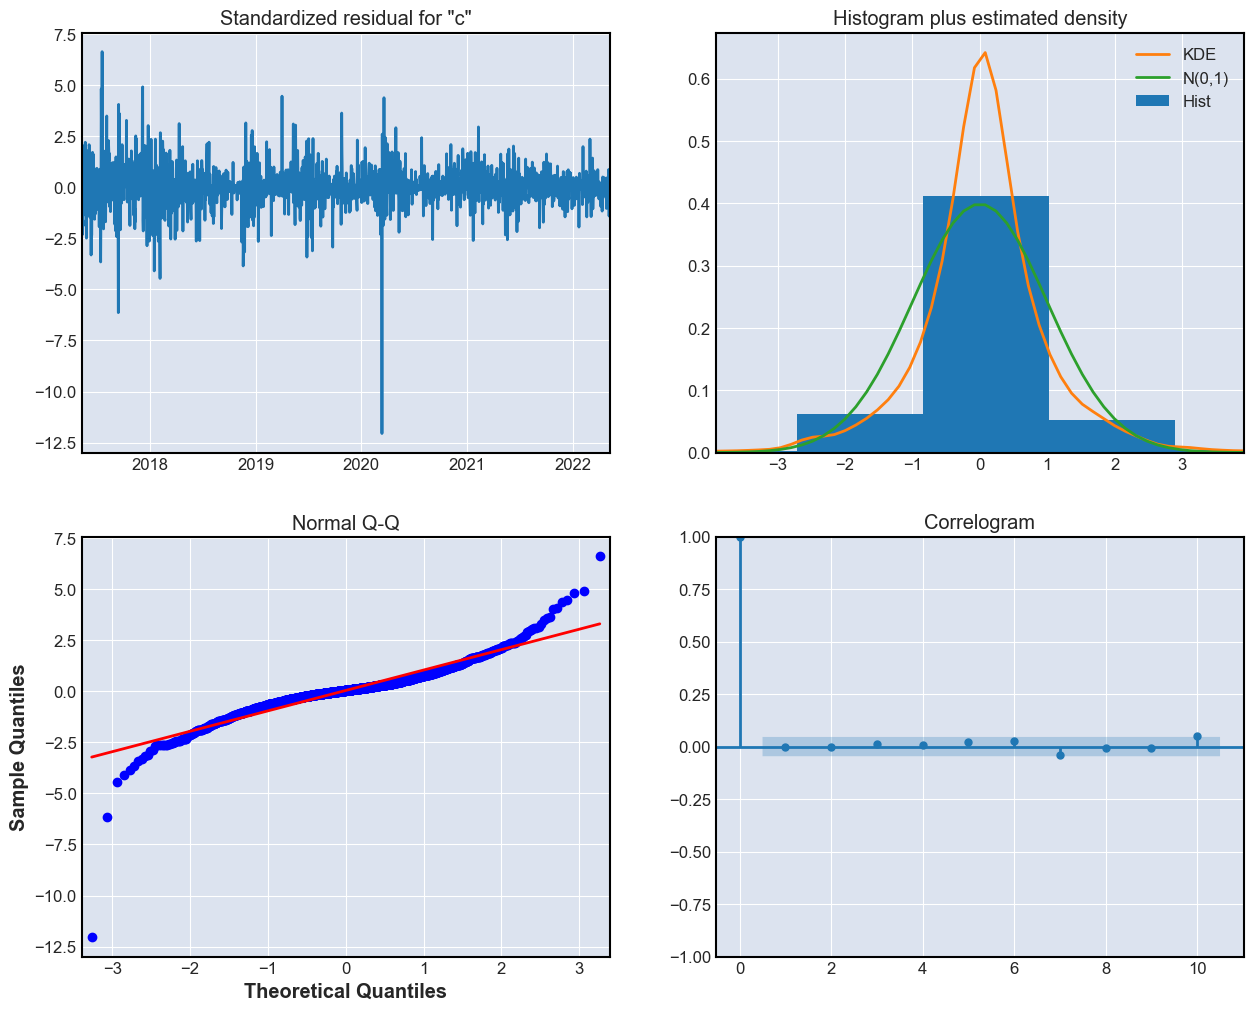

In [199]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [200]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [201]:
btc_month_pred = btc_daily[['close']]
date_list = [datetime(2022, 5, 9), datetime(2022, 5, 10)]
date_list = pd.DataFrame(data=date_list)
date_list=date_list.rename(columns={0:'Date'})

In [202]:
future2 = pd.concat([BTC_rindex,date_list])
future3 = pd.concat([df_ada,date_list])

In [203]:
date_list=date_list.set_index('Date')

In [204]:
future = pd.concat([df_btc,date_list])
btc_month_pred = pd.concat([btc_month_pred, future])
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2022, 4, 1), 
                                                          end=datetime(2022, 5, 10)), lmbda)



In [205]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                 1826
Model:               SARIMAX(0, 1, 2)   Log Likelihood                6699.924
Date:                Sat, 28 May 2022   AIC                         -13393.848
Time:                        18:32:05   BIC                         -13377.320
Sample:                    05-09-2017   HQIC                        -13387.751
                         - 05-08-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0354      0.015     -2.300      0.021      -0.066      -0.005
ma.L2          0.0425      0.019      2.256      0.024       0.006       0.079
sigma2      3.791e-05   4.26e-07     88.907      0.0

In [206]:
btc_month_pred.tail(5)

,close,crypto,high,low,open,volume,adj_close,diff,gain,loss,...,avg_loss,rs,rsi,bollinger,macd,macd_sig,macd_cd,STOCHk_14_3_3,STOCHd_14_3_3,forecast
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-06,36040.921875,BTC,36624.359375,35482.132812,36573.183594,3.779558e+10,36040.921875,-534.21875,0.0,534.22,...,642.564106,0.580877,36.743974,39181.136523,-1193.692814,-170.235188,-1023.457627,21.695549,20.364804,36753.482627
2022-05-07,35501.953125,BTC,36129.925781,34940.824219,36042.503906,2.437590e+10,35501.953125,-538.96875,0.0,538.97,...,635.164527,0.545670,35.303121,38970.386523,-1327.247911,-243.032228,-1084.215684,11.667666,17.511217,35945.873388
2022-05-08,34226.796875,BTC,35477.484375,33913.957031,35473.250000,3.694594e+10,34226.796875,-1275.15625,0.0,1275.16,...,680.878490,0.472674,32.096309,38640.415625,-1518.481629,-347.412757,-1171.068873,8.333706,13.898973,35488.154385
2022-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34252.589456
2022-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34200.106892


In [207]:
y_forecasted = btc_month_pred.forecast
y_truth = btc_month_pred.loc['2022-04-23':'2022-4-25'].close

In [208]:
y_truth

Date
2022-04-23    39486.730469
2022-04-24    39469.292969
2022-04-25    40458.308594
2022-04-23    39486.730469
2022-04-24    39469.292969
2022-04-25    40458.308594
Name: close, dtype: float64

In [209]:
y_forecasted.tail(5)

Date
2022-05-06    36753.482627
2022-05-07    35945.873388
2022-05-08    35488.154385
2022-05-09    34252.589456
2022-05-10    34200.106892
Name: forecast, dtype: float64

In [210]:
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 594.37


# BTC Pred with TimeBased CV split

In [211]:
import datetime
tscv = TimeBasedCV(train_period=5,
                   test_period=2,
                   freq='days')
for train_index, test_index in tscv.split(BTC_rindex,
                   validation_split_date=datetime.date(2022,4,1), date_column='Date'):
    print(train_index, test_index)

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

In [212]:
future2=future2.reset_index(drop=True).drop('crypto',axis=1)
#only for BTC

In [213]:
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = future2
y = future2['close']


scores = []
for train_index, test_index in tscv.split(X, validation_split_date=datetime.date(2022,4,1)):
    data_train   = X.loc[train_index].drop('Date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('Date', axis=1)
    target_test  = y.loc[test_index]

    # if needed, do preprocessing here

    clf = LinearRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)
    
    # accuracy for the current fold only    
    r2score = clf.score(data_test,target_test)

    scores.append(r2score)

# this is the average accuracy over all folds
average_r2score = np.mean(scores)
#### End of example ####


tscv = TimeBasedCV(train_period=5, test_period=2)
index_output = tscv.split(BTC_rindex, validation_split_date=datetime.date(2022,4,1))

lgbm = LGBMRegressor()

lgbmPd = {" max_depth": [-1,2]
         }

model = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbmPd,
    n_iter = 1,
    n_jobs = -1,
    iid = True,
    cv = index_output,
    verbose=5,
    pre_dispatch='2*n_jobs',
    random_state = None,
    return_train_score = True)

model.fit(X.drop('Date', axis=1),y)
model.cv_results_

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    5.2s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    5.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    5.2s remaining:    1.0s


[LightGBM] [Warning] max_depth is set=-1, max_depth=-1 will be ignored. Current value: max_depth=-1


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    5.3s finished


{'mean_fit_time': array([0.01089153]),
 'std_fit_time': array([0.00622623]),
 'mean_score_time': array([0.00472384]),
 'std_score_time': array([0.00305121]),
 'param_ max_depth': masked_array(data=[-1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{' max_depth': -1}],
 'split0_test_score': array([-12.44069381]),
 'split1_test_score': array([-1.25140905]),
 'split2_test_score': array([-2.2750903]),
 'split3_test_score': array([-18.93150306]),
 'split4_test_score': array([-36.71730551]),
 'split5_test_score': array([-96.50625299]),
 'split6_test_score': array([-1.8362038]),
 'split7_test_score': array([-2.54225684]),
 'split8_test_score': array([-0.09382893]),
 'split9_test_score': array([-319.47175897]),
 'split10_test_score': array([-2.6047563]),
 'split11_test_score': array([-22789.31117586]),
 'split12_test_score': array([-0.50498788]),
 'split13_test_score': array([-0.03967216]),
 'split14_test_score': array([-7.79905337]),
 'split15_te

In [214]:
Labels_Test1 = model.predict(data_test)
Labels_Test1 = pd.DataFrame(Labels_Test1)

In [215]:
data_test

,high,low,close,open,volume,adj_close,diff,gain,loss,avg_gain,avg_loss,rs,rsi,bollinger,macd,macd_sig,macd_cd,STOCHk_14_3_3,STOCHd_14_3_3
1824,36129.925781,34940.824219,35501.953125,36042.503906,2.437590e+10,35501.953125,-538.96875,0.0,538.97,346.589980,635.164527,0.545670,35.303121,38970.386523,-1327.247911,-243.032228,-1084.215684,11.667666,17.511217
1825,35477.484375,33913.957031,34226.796875,35473.250000,3.694594e+10,34226.796875,-1275.15625,0.0,1275.16,321.833553,680.878490,0.472674,32.096309,38640.415625,-1518.481629,-347.412757,-1171.068873,8.333706,13.898973


In [216]:
BTC_rindex.tail(2)

,Date,crypto,high,low,close,open,volume,adj_close,diff,gain,...,avg_gain,avg_loss,rs,rsi,bollinger,macd,macd_sig,macd_cd,STOCHk_14_3_3,STOCHd_14_3_3
1824,2022-05-07,BTC,36129.925781,34940.824219,35501.953125,36042.503906,2.437590e+10,35501.953125,-538.96875,0.0,...,346.589980,635.164527,0.545670,35.303121,38970.386523,-1327.247911,-243.032228,-1084.215684,11.667666,17.511217
1825,2022-05-08,BTC,35477.484375,33913.957031,34226.796875,35473.250000,3.694594e+10,34226.796875,-1275.15625,0.0,...,321.833553,680.878490,0.472674,32.096309,38640.415625,-1518.481629,-347.412757,-1171.068873,8.333706,13.898973


In [339]:
Labels_Test1.round(2).to_csv('btc_pred.csv')
#add back as forecasted column

<AxesSubplot:xlabel='importances', ylabel='features'>

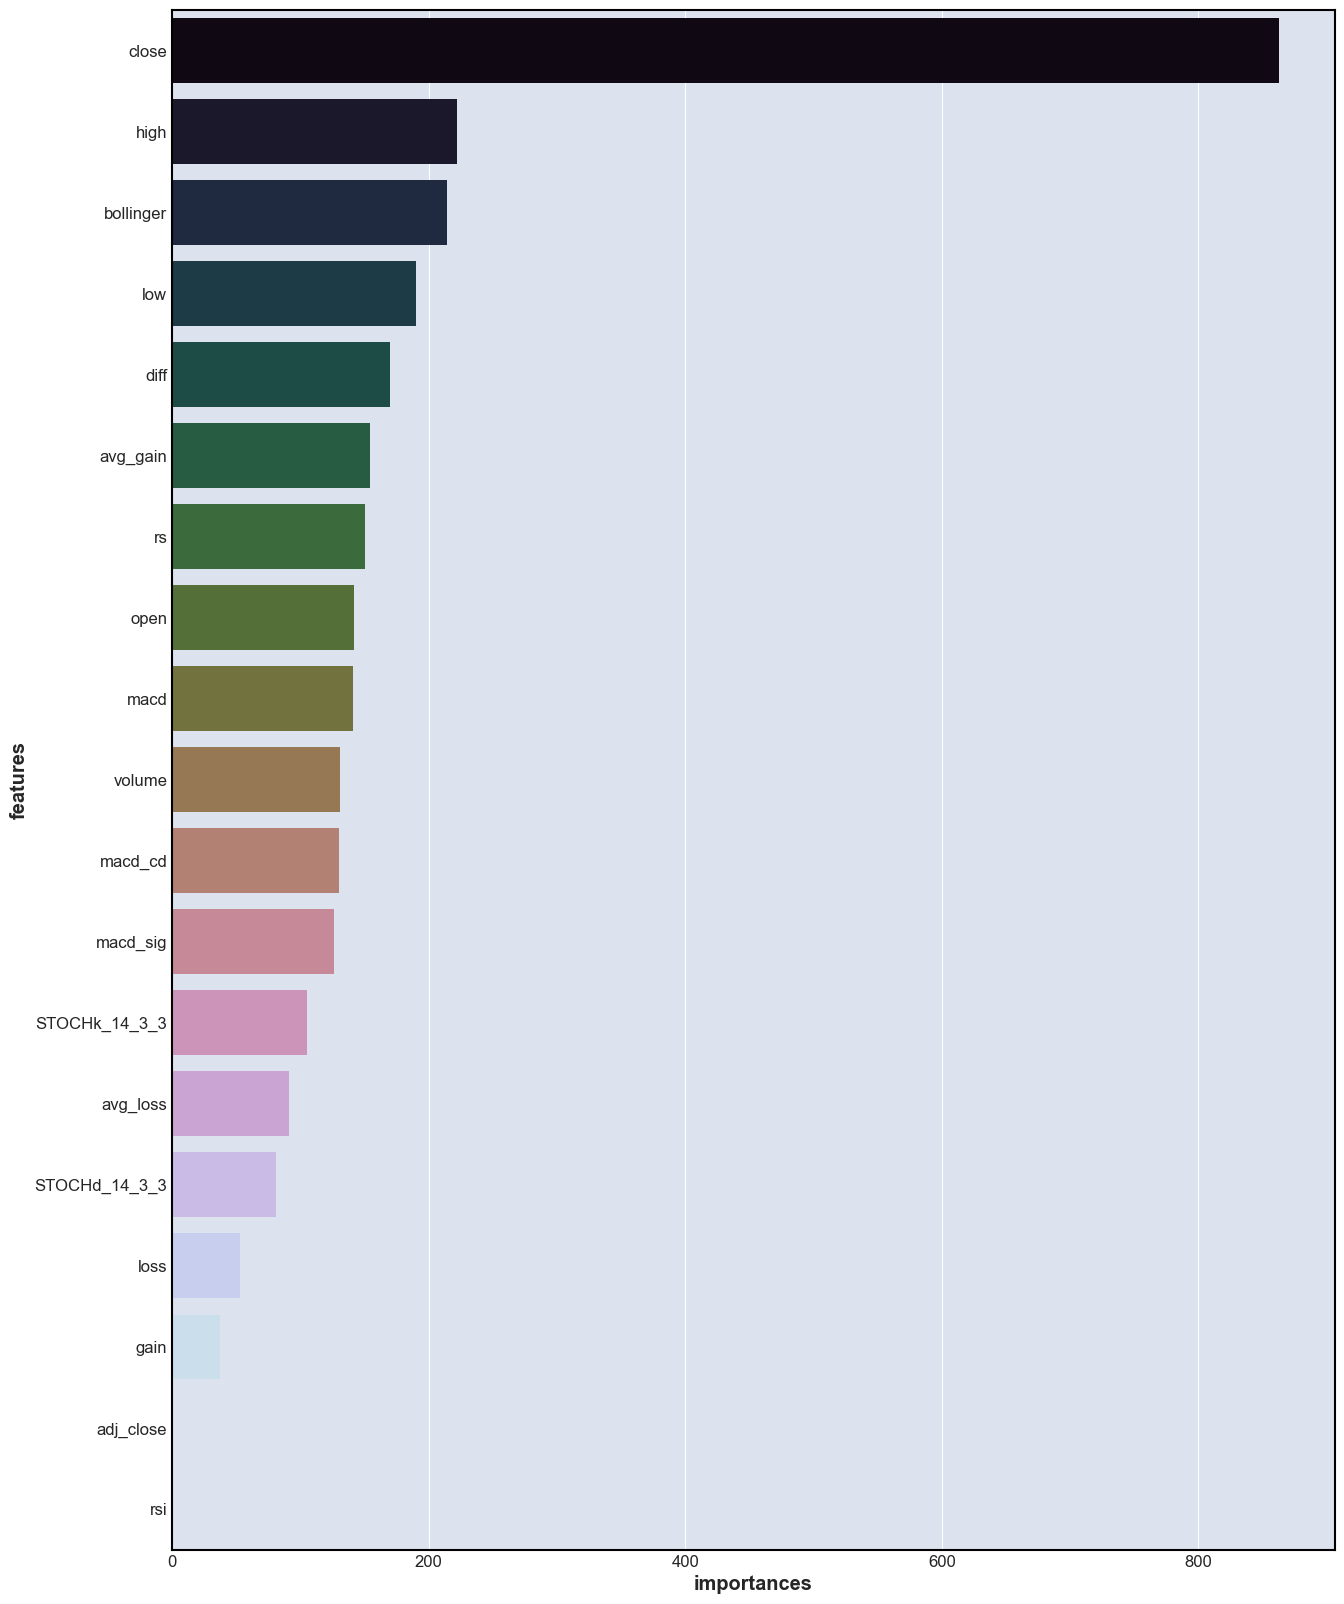

In [218]:
ab = lgbm.fit(X.drop('Date', axis=1),y)
plt.figure(figsize=(15,20))
importances = ab.feature_importances_
features = X.drop('Date', axis=1).columns
data_tuples = list(zip(importances, features))
data_1 = pd.DataFrame(data_tuples, columns = ['importances', 'features'])
data_1 = data_1.sort_values('importances', ascending = False)
sns.barplot(data_1['importances'], data_1['features'], palette = 'cubehelix', orient = 'h')

# Analyzing low closing & high closing prices for BTC

In [219]:
df_btc.loc['2021-07-18':'2021-07-27']

,crypto,high,low,close,open,volume,adj_close,diff,gain,loss,avg_gain,avg_loss,rs,rsi,bollinger,macd,macd_sig,macd_cd,STOCHk_14_3_3,STOCHd_14_3_3
Date,,,,,,,,,,,,,,,,,,,,
2021-07-18,BTC,32398.996094,31215.492188,31796.810547,31533.884766,1.878799e+10,31796.810547,263.742188,263.74,0.00,329.119385,478.316689,0.688078,40.761045,33490.954590,-1029.383007,-85.913653,-943.469355,10.737532,11.928606
2021-07-19,BTC,31885.859375,30563.734375,30817.832031,31800.011719,2.043479e+10,30817.832031,-978.978516,0.00,978.98,305.610857,514.078354,0.594483,37.283748,33238.457324,-1097.463528,-123.195338,-974.268189,10.419101,10.194299
2021-07-20,BTC,31006.187500,29360.955078,29807.347656,30838.285156,2.314827e+10,29807.347656,-1010.484375,0.00,1010.48,283.781510,549.535614,0.516402,34.054444,32976.782910,-1218.904700,-195.709209,-1023.195491,10.079058,10.411897
2021-07-21,BTC,32752.326172,29526.183594,32110.693359,29796.285156,2.820302e+10,32110.693359,2303.345703,2303.35,0.00,428.036402,510.283070,0.838821,45.617342,32903.711719,-1116.417589,-74.577678,-1041.839911,22.053994,14.184051
2021-07-22,BTC,32576.400391,31745.298828,32313.105469,32138.873047,1.955523e+10,32313.105469,202.412109,202.41,0.00,411.920231,473.834280,0.869334,46.505011,32824.514648,-1007.251876,27.670428,-1034.922304,38.972359,23.701804
2021-07-23,BTC,33581.550781,32057.892578,33581.550781,32305.958984,2.255205e+10,33581.550781,1268.445312,1268.45,0.00,473.100929,439.988974,1.075256,51.813182,32770.164844,-809.058010,180.691435,-989.749445,63.226297,41.417550
2021-07-24,BTC,34490.390625,33424.859375,34292.445312,33593.730469,2.166471e+10,34292.445312,710.894531,710.89,0.00,490.085862,408.561190,1.199541,54.535967,32720.398047,-587.848345,321.520880,-909.369225,77.128470,59.775709
2021-07-25,BTC,35364.925781,33881.835938,35350.187500,34290.292969,2.085669e+10,35350.187500,1057.742188,1057.74,0.00,530.632586,379.378248,1.398690,58.310579,32800.607227,-323.458509,468.728573,-792.187082,91.568809,77.307859
2021-07-26,BTC,40499.675781,35287.312500,37337.535156,35384.031250,5.102213e+10,37337.535156,1987.347656,1987.35,0.00,634.683830,352.279802,1.801647,64.306709,32955.724219,45.905517,670.474079,-624.568562,88.545502,85.747594


In [220]:
df_btc.loc['2021-11-07':'2021-11-14']

,crypto,high,low,close,open,volume,adj_close,diff,gain,loss,avg_gain,avg_loss,rs,rsi,bollinger,macd,macd_sig,macd_cd,STOCHk_14_3_3,STOCHd_14_3_3
Date,,,,,,,,,,,,,,,,,,,,
2021-11-07,BTC,63326.988281,61432.488281,63326.988281,61554.921875,2.472675e+10,63326.988281,1799.507812,1799.51,0.00,772.662022,514.818719,1.500843,60.013482,61902.942187,1662.357001,-379.345895,2041.702895,62.732637,56.022935
2021-11-08,BTC,67673.742188,63344.066406,67566.828125,63344.066406,4.112561e+10,67566.828125,4239.839844,4239.84,0.00,1020.317592,478.045954,2.134350,68.095463,62068.183984,2000.529841,-32.938444,2033.468284,79.570575,64.894144
2021-11-09,BTC,68530.335938,66382.062500,66971.828125,67549.734375,4.235799e+10,66971.828125,-595.000000,0.00,595.00,947.437764,486.399814,1.947858,66.077063,62117.133594,2195.217623,129.399471,2065.818152,89.533711,77.278974
2021-11-10,BTC,68789.625000,63208.113281,64995.230469,66953.335938,4.873083e+10,64995.230469,-1976.597656,0.00,1976.60,879.763638,592.842684,1.483975,59.741944,62256.386523,2165.056755,79.390883,2085.665873,82.639719,83.914668
2021-11-11,BTC,65579.015625,64180.488281,64949.960938,64978.890625,3.588063e+10,64949.960938,-45.269531,0.00,45.27,816.923378,553.730350,1.475309,59.601004,62469.271289,2113.142190,21.981053,2091.161136,68.942871,80.372100
2021-11-12,BTC,65460.816406,62333.914062,64155.941406,64863.980469,3.608489e+10,64155.941406,-794.019531,0.00,794.02,758.571708,570.893896,1.328744,57.058393,62607.387500,1985.046403,-84.891787,2069.938189,56.991570,69.524720
2021-11-13,BTC,64915.675781,63303.734375,64469.527344,64158.121094,3.047423e+10,64469.527344,313.585938,313.59,0.00,726.787301,530.115761,1.370997,57.823656,62784.322070,1887.080247,-146.286354,2033.366601,53.108920,59.681120
2021-11-14,BTC,65495.179688,63647.808594,65466.839844,64455.371094,2.512209e+10,65466.839844,997.312500,997.31,0.00,746.110351,492.250349,1.515713,60.249841,62905.672852,1868.378640,-131.990369,2000.369009,55.003407,55.034632


# ADA Predictions

In [221]:
tscv = TimeBasedCV(train_period=5,
                   test_period=2,
                   freq='days')
for train_index, test_index in tscv.split(df_ada,
                   validation_split_date=datetime.date(2022,4,1), date_column='Date'):
    print(train_index, test_index)

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

In [222]:
future3=future3.drop(['crypto'], axis=1)

In [223]:
future3=future3.reset_index(drop=True)

In [224]:
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = future3
y = future3['close']


scores = []
for train_index, test_index in tscv.split(X, validation_split_date=datetime.date(2022,4,1)):
    data_train   = X.loc[train_index].drop('Date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('Date', axis=1)
    target_test  = y.loc[test_index]

    # if needed, do preprocessing here

    clf = LinearRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)
    
    # accuracy for the current fold only    
    r2score = clf.score(data_test,target_test)

    scores.append(r2score)

# this is the average accuracy over all folds
average_r2score = np.mean(scores)
#### End of example ####


tscv = TimeBasedCV(train_period=5, test_period=2)
index_output = tscv.split(future3, validation_split_date=datetime.date(2022,4,1))

lgbm = LGBMRegressor()

lgbmPd = {" max_depth": [-1,2]
         }

model = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbmPd,
    n_iter = 1,
    n_jobs = -1,
    iid = True,
    cv = index_output,
    verbose=5,
    pre_dispatch='2*n_jobs',
    random_state = None,
    return_train_score = True)

model.fit(X.drop('Date', axis=1),y)
model.cv_results_

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.0s finished


{'mean_fit_time': array([0.00673309]),
 'std_fit_time': array([0.00243135]),
 'mean_score_time': array([0.00310597]),
 'std_score_time': array([0.00096636]),
 'param_ max_depth': masked_array(data=[-1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{' max_depth': -1}],
 'split0_test_score': array([-9.37741097]),
 'split1_test_score': array([-5.09838641]),
 'split2_test_score': array([-1.05609839]),
 'split3_test_score': array([-8.67913614]),
 'split4_test_score': array([-106.75564726]),
 'split5_test_score': array([-41.37172122]),
 'split6_test_score': array([-3.94836894]),
 'split7_test_score': array([-75.76082296]),
 'split8_test_score': array([-7.75553832]),
 'split9_test_score': array([-0.66978858]),
 'split10_test_score': array([-341.76392495]),
 'split11_test_score': array([-1491.84389726]),
 'split12_test_score': array([-1.45112847]),
 'split13_test_score': array([-551.57927621]),
 'split14_test_score': array([-10.55528321]),
 'split

In [225]:
Labels_Test_ada = model.predict(data_test)
Labels_Test_ada = pd.DataFrame(Labels_Test_ada)

In [340]:
Labels_Test_ada.round(2).to_csv('ada_pred.csv')

# ETH Pred

In [227]:
tscv = TimeBasedCV(train_period=5,
                   test_period=2,
                   freq='days')
for train_index, test_index in tscv.split(df_eth,
                   validation_split_date=datetime.date(2022,4,1), date_column='Date'):
    print(train_index, test_index)

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

In [228]:
future3 = pd.concat([df_eth,date_list])
future3=future3.drop(['crypto'], axis=1)

In [229]:
future3=future3.reset_index(drop=True)

In [230]:
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = future3
y = future3['close']


scores = []
for train_index, test_index in tscv.split(X, validation_split_date=datetime.date(2022,4,1)):
    data_train   = X.loc[train_index].drop('Date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('Date', axis=1)
    target_test  = y.loc[test_index]

    # if needed, do preprocessing here

    clf = LinearRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)
    
    # accuracy for the current fold only    
    r2score = clf.score(data_test,target_test)

    scores.append(r2score)

# this is the average accuracy over all folds
average_r2score = np.mean(scores)
#### End of example ####


tscv = TimeBasedCV(train_period=5, test_period=2)
index_output = tscv.split(future3, validation_split_date=datetime.date(2022,4,1))

lgbm = LGBMRegressor()

lgbmPd = {" max_depth": [-1,2]
         }

model = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbmPd,
    n_iter = 1,
    n_jobs = -1,
    iid = True,
    cv = index_output,
    verbose=5,
    pre_dispatch='2*n_jobs',
    random_state = None,
    return_train_score = True)

model.fit(X.drop('Date', axis=1),y)
model.cv_results_

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished


{'mean_fit_time': array([0.00872293]),
 'std_fit_time': array([0.00288324]),
 'mean_score_time': array([0.00338822]),
 'std_score_time': array([0.00153361]),
 'param_ max_depth': masked_array(data=[2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{' max_depth': 2}],
 'split0_test_score': array([-2307.23017011]),
 'split1_test_score': array([-26399.78228814]),
 'split2_test_score': array([-1.60993421]),
 'split3_test_score': array([-96.00766861]),
 'split4_test_score': array([-7.62977783]),
 'split5_test_score': array([-71.44058261]),
 'split6_test_score': array([-1.81629786]),
 'split7_test_score': array([-3.74348684]),
 'split8_test_score': array([-0.80859129]),
 'split9_test_score': array([-18.11453816]),
 'split10_test_score': array([-53.57664227]),
 'split11_test_score': array([-196.95615518]),
 'split12_test_score': array([-0.4755236]),
 'split13_test_score': array([-0.42989163]),
 'split14_test_score': array([-10.80208008]),
 'split1

In [231]:
Labels_Test_eth = model.predict(data_test)
Labels_Test_eth = pd.DataFrame(Labels_Test_eth)

In [341]:
Labels_Test_eth.round(2).to_csv('eth_pred.csv')

# AXS Pred

In [233]:
tscv = TimeBasedCV(train_period=5,
                   test_period=2,
                   freq='days')
for train_index, test_index in tscv.split(df_axs,
                   validation_split_date=datetime.date(2022,4,1), date_column='Date'):
    print(train_index, test_index)

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

In [234]:
future3 = pd.concat([df_axs,date_list])
future3=future3.drop(['crypto'], axis=1)

In [235]:
future3=future3.reset_index(drop=True)

In [236]:
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = future3
y = future3['close']


scores = []
for train_index, test_index in tscv.split(X, validation_split_date=datetime.date(2022,4,1)):
    data_train   = X.loc[train_index].drop('Date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('Date', axis=1)
    target_test  = y.loc[test_index]

    # if needed, do preprocessing here

    clf = LinearRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)
    
    # accuracy for the current fold only    
    r2score = clf.score(data_test,target_test)

    scores.append(r2score)

# this is the average accuracy over all folds
average_r2score = np.mean(scores)
#### End of example ####


tscv = TimeBasedCV(train_period=5, test_period=2)
index_output = tscv.split(future3, validation_split_date=datetime.date(2022,4,1))

lgbm = LGBMRegressor()

lgbmPd = {" max_depth": [-1,2]
         }

model = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbmPd,
    n_iter = 1,
    n_jobs = -1,
    iid = True,
    cv = index_output,
    verbose=5,
    pre_dispatch='2*n_jobs',
    random_state = None,
    return_train_score = True)

model.fit(X.drop('Date', axis=1),y)
model.cv_results_

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished


{'mean_fit_time': array([0.00750005]),
 'std_fit_time': array([0.00332162]),
 'mean_score_time': array([0.00338965]),
 'std_score_time': array([0.00142137]),
 'param_ max_depth': masked_array(data=[2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{' max_depth': 2}],
 'split0_test_score': array([-0.69673621]),
 'split1_test_score': array([-0.13322088]),
 'split2_test_score': array([-3.29661213]),
 'split3_test_score': array([-20.19030282]),
 'split4_test_score': array([-24.52665143]),
 'split5_test_score': array([-25.09337956]),
 'split6_test_score': array([-2.03464197]),
 'split7_test_score': array([-2.74051803]),
 'split8_test_score': array([-26.33426472]),
 'split9_test_score': array([-6.7085099e-06]),
 'split10_test_score': array([-5.75414015]),
 'split11_test_score': array([-11.86940555]),
 'split12_test_score': array([-4.45255805]),
 'split13_test_score': array([-166.66654853]),
 'split14_test_score': array([-11.82329058]),
 'split15_

In [237]:
Labels_Test_axs = model.predict(data_test)
Labels_Test_axs = pd.DataFrame(Labels_Test_axs)

In [342]:
Labels_Test_axs.round(2).to_csv('axs_pred.csv')

# LINK Pred

In [239]:
tscv = TimeBasedCV(train_period=5,
                   test_period=2,
                   freq='days')
for train_index, test_index in tscv.split(df_link,
                   validation_split_date=datetime.date(2022,4,1), date_column='Date'):
    print(train_index, test_index)

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

In [240]:
future3 = pd.concat([df_link,date_list])
future3=future3.drop(['crypto'], axis=1)

In [241]:
future3=future3.reset_index(drop=True)

In [242]:
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = future3
y = future3['close']


scores = []
for train_index, test_index in tscv.split(X, validation_split_date=datetime.date(2022,4,1)):
    data_train   = X.loc[train_index].drop('Date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('Date', axis=1)
    target_test  = y.loc[test_index]

    # if needed, do preprocessing here

    clf = LinearRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)
    
    # accuracy for the current fold only    
    r2score = clf.score(data_test,target_test)

    scores.append(r2score)

# this is the average accuracy over all folds
average_r2score = np.mean(scores)
#### End of example ####


tscv = TimeBasedCV(train_period=5, test_period=2)
index_output = tscv.split(future3, validation_split_date=datetime.date(2022,4,1))

lgbm = LGBMRegressor()

lgbmPd = {" max_depth": [-1,2]
         }

model = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbmPd,
    n_iter = 1,
    n_jobs = -1,
    iid = True,
    cv = index_output,
    verbose=5,
    pre_dispatch='2*n_jobs',
    random_state = None,
    return_train_score = True)

model.fit(X.drop('Date', axis=1),y)
model.cv_results_

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished


{'mean_fit_time': array([0.00766791]),
 'std_fit_time': array([0.00210782]),
 'mean_score_time': array([0.00405586]),
 'std_score_time': array([0.00150869]),
 'param_ max_depth': masked_array(data=[-1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{' max_depth': -1}],
 'split0_test_score': array([-105.21420003]),
 'split1_test_score': array([-4.03844471]),
 'split2_test_score': array([-3.95477825]),
 'split3_test_score': array([-24.34442685]),
 'split4_test_score': array([-295.81467444]),
 'split5_test_score': array([-199.84796282]),
 'split6_test_score': array([-9.15464882]),
 'split7_test_score': array([-9.19149746]),
 'split8_test_score': array([-0.69369027]),
 'split9_test_score': array([-2.83453113]),
 'split10_test_score': array([-1890.96146475]),
 'split11_test_score': array([-436.35769329]),
 'split12_test_score': array([-1.44676213]),
 'split13_test_score': array([-212.8468505]),
 'split14_test_score': array([-8.46370951]),
 'spli

In [243]:
Labels_Test_link = model.predict(data_test)
Labels_Test_link = pd.DataFrame(Labels_Test_link)

In [343]:
Labels_Test_link.round(2).to_csv('link_pred.csv')

# AVAX Pred

In [245]:
tscv = TimeBasedCV(train_period=5,
                   test_period=2,
                   freq='days')
for train_index, test_index in tscv.split(df_avax,
                   validation_split_date=datetime.date(2022,4,1), date_column='Date'):
    print(train_index, test_index)

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

In [246]:
future3 = pd.concat([df_avax,date_list])
future3=future3.drop(['crypto'], axis=1)

In [247]:
future3=future3.reset_index(drop=True)

In [248]:
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = future3
y = future3['close']


scores = []
for train_index, test_index in tscv.split(X, validation_split_date=datetime.date(2022,4,1)):
    data_train   = X.loc[train_index].drop('Date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('Date', axis=1)
    target_test  = y.loc[test_index]

    # if needed, do preprocessing here

    clf = LinearRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)
    
    # accuracy for the current fold only    
    r2score = clf.score(data_test,target_test)

    scores.append(r2score)

# this is the average accuracy over all folds
average_r2score = np.mean(scores)
#### End of example ####


tscv = TimeBasedCV(train_period=5, test_period=2)
index_output = tscv.split(future3, validation_split_date=datetime.date(2022,4,1))

lgbm = LGBMRegressor()

lgbmPd = {" max_depth": [-1,2]
         }

model = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbmPd,
    n_iter = 1,
    n_jobs = -1,
    iid = True,
    cv = index_output,
    verbose=5,
    pre_dispatch='2*n_jobs',
    random_state = None,
    return_train_score = True)

model.fit(X.drop('Date', axis=1),y)
model.cv_results_

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished


{'mean_fit_time': array([0.00694466]),
 'std_fit_time': array([0.00214618]),
 'mean_score_time': array([0.00333365]),
 'std_score_time': array([0.00129111]),
 'param_ max_depth': masked_array(data=[-1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{' max_depth': -1}],
 'split0_test_score': array([-86.00618871]),
 'split1_test_score': array([-0.81804248]),
 'split2_test_score': array([-5.72564786]),
 'split3_test_score': array([-10.94378713]),
 'split4_test_score': array([-13.12115876]),
 'split5_test_score': array([-66.88537087]),
 'split6_test_score': array([-1.18445782]),
 'split7_test_score': array([-0.56329401]),
 'split8_test_score': array([-0.83100172]),
 'split9_test_score': array([-4.57111383]),
 'split10_test_score': array([-50.07616939]),
 'split11_test_score': array([-54.24835061]),
 'split12_test_score': array([-2.99534845]),
 'split13_test_score': array([-7.38320706]),
 'split14_test_score': array([-9.53092079]),
 'split15_tes

In [249]:
Labels_Test_avax = model.predict(data_test)
Labels_Test_avax = pd.DataFrame(Labels_Test_avax)

In [344]:
Labels_Test_avax.round(2).to_csv('avax_pred.csv')

# LUNA1 Pred

In [251]:
tscv = TimeBasedCV(train_period=5,
                   test_period=2,
                   freq='days')
for train_index, test_index in tscv.split(df_luna,
                   validation_split_date=datetime.date(2022,4,1), date_column='Date'):
    print(train_index, test_index)

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

In [252]:
future3 = pd.concat([df_luna,date_list])
future3=future3.drop(['crypto'], axis=1)

In [253]:
future3=future3.reset_index(drop=True)

In [254]:
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = future3
y = future3['close']


scores = []
for train_index, test_index in tscv.split(X, validation_split_date=datetime.date(2022,4,1)):
    data_train   = X.loc[train_index].drop('Date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('Date', axis=1)
    target_test  = y.loc[test_index]

    # if needed, do preprocessing here

    clf = LinearRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)
    
    # accuracy for the current fold only    
    r2score = clf.score(data_test,target_test)

    scores.append(r2score)

# this is the average accuracy over all folds
average_r2score = np.mean(scores)
#### End of example ####


tscv = TimeBasedCV(train_period=5, test_period=2)
index_output = tscv.split(future3, validation_split_date=datetime.date(2022,4,1))

lgbm = LGBMRegressor()

lgbmPd = {" max_depth": [-1,2]
         }

model = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbmPd,
    n_iter = 1,
    n_jobs = -1,
    iid = True,
    cv = index_output,
    verbose=5,
    pre_dispatch='2*n_jobs',
    random_state = None,
    return_train_score = True)

model.fit(X.drop('Date', axis=1),y)
model.cv_results_

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished


{'mean_fit_time': array([0.00794597]),
 'std_fit_time': array([0.00147031]),
 'mean_score_time': array([0.00372157]),
 'std_score_time': array([0.00184925]),
 'param_ max_depth': masked_array(data=[2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{' max_depth': 2}],
 'split0_test_score': array([-3.32484209]),
 'split1_test_score': array([-17.29490875]),
 'split2_test_score': array([-0.09966352]),
 'split3_test_score': array([-10.65574862]),
 'split4_test_score': array([-27.59019117]),
 'split5_test_score': array([-223.81543129]),
 'split6_test_score': array([-3.5460351]),
 'split7_test_score': array([-234.18962736]),
 'split8_test_score': array([-0.03193152]),
 'split9_test_score': array([-1548.50935923]),
 'split10_test_score': array([-8.5829906]),
 'split11_test_score': array([-38.41365687]),
 'split12_test_score': array([-0.04367769]),
 'split13_test_score': array([-1965.48447712]),
 'split14_test_score': array([-7.23741268]),
 'split15

In [255]:
Labels_Test_luna = model.predict(data_test)
Labels_Test_luna = pd.DataFrame(Labels_Test_luna)

In [345]:
Labels_Test_luna.round(2).to_csv('luna1_pred.csv')

# MATIC Pred

In [257]:
tscv = TimeBasedCV(train_period=5,
                   test_period=2,
                   freq='days')
for train_index, test_index in tscv.split(df_matic,
                   validation_split_date=datetime.date(2022,4,1), date_column='Date'):
    print(train_index, test_index)

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

In [258]:
future3 = pd.concat([df_matic,date_list])
future3=future3.drop(['crypto'], axis=1)

In [259]:
future3=future3.reset_index(drop=True)

In [260]:
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = future3
y = future3['close']


scores = []
for train_index, test_index in tscv.split(X, validation_split_date=datetime.date(2022,4,1)):
    data_train   = X.loc[train_index].drop('Date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('Date', axis=1)
    target_test  = y.loc[test_index]

    # if needed, do preprocessing here

    clf = LinearRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)
    
    # accuracy for the current fold only    
    r2score = clf.score(data_test,target_test)

    scores.append(r2score)

# this is the average accuracy over all folds
average_r2score = np.mean(scores)
#### End of example ####


tscv = TimeBasedCV(train_period=5, test_period=2)
index_output = tscv.split(future3, validation_split_date=datetime.date(2022,4,1))

lgbm = LGBMRegressor()

lgbmPd = {" max_depth": [-1,2]
         }

model = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbmPd,
    n_iter = 1,
    n_jobs = -1,
    iid = True,
    cv = index_output,
    verbose=5,
    pre_dispatch='2*n_jobs',
    random_state = None,
    return_train_score = True)

model.fit(X.drop('Date', axis=1),y)
model.cv_results_

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished


{'mean_fit_time': array([0.00833151]),
 'std_fit_time': array([0.00242821]),
 'mean_score_time': array([0.00372222]),
 'std_score_time': array([0.00132622]),
 'param_ max_depth': masked_array(data=[2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{' max_depth': 2}],
 'split0_test_score': array([-0.15521077]),
 'split1_test_score': array([-0.05207993]),
 'split2_test_score': array([-4.04679628]),
 'split3_test_score': array([-11.70065384]),
 'split4_test_score': array([-27.81854482]),
 'split5_test_score': array([-10.83297546]),
 'split6_test_score': array([-0.42835563]),
 'split7_test_score': array([-1.38136641]),
 'split8_test_score': array([-0.11890009]),
 'split9_test_score': array([-55.09266231]),
 'split10_test_score': array([-1.10145874]),
 'split11_test_score': array([-24.80909119]),
 'split12_test_score': array([-2.3197976]),
 'split13_test_score': array([-97.40083511]),
 'split14_test_score': array([-14.4294269]),
 'split15_test_s

In [261]:
Labels_Test_matic = model.predict(data_test)
Labels_Test_matic = pd.DataFrame(Labels_Test_matic)

In [346]:
Labels_Test_matic.round(2).to_csv('matic_pred.csv')

# ATOM Pred

In [263]:
tscv = TimeBasedCV(train_period=5,
                   test_period=2,
                   freq='days')
for train_index, test_index in tscv.split(df_atom,
                   validation_split_date=datetime.date(2022,4,1), date_column='Date'):
    print(train_index, test_index)

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

In [264]:
future3 = pd.concat([df_atom,date_list])
future3=future3.drop(['crypto'], axis=1)

In [265]:
future3=future3.reset_index(drop=True)

In [266]:
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = future3
y = future3['close']


scores = []
for train_index, test_index in tscv.split(X, validation_split_date=datetime.date(2022,4,1)):
    data_train   = X.loc[train_index].drop('Date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('Date', axis=1)
    target_test  = y.loc[test_index]

    # if needed, do preprocessing here

    clf = LinearRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)
    
    # accuracy for the current fold only    
    r2score = clf.score(data_test,target_test)

    scores.append(r2score)

# this is the average accuracy over all folds
average_r2score = np.mean(scores)
#### End of example ####


tscv = TimeBasedCV(train_period=5, test_period=2)
index_output = tscv.split(future3, validation_split_date=datetime.date(2022,4,1))

lgbm = LGBMRegressor()

lgbmPd = {" max_depth": [-1,2]
         }

model = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbmPd,
    n_iter = 1,
    n_jobs = -1,
    iid = True,
    cv = index_output,
    verbose=5,
    pre_dispatch='2*n_jobs',
    random_state = None,
    return_train_score = True)

model.fit(X.drop('Date', axis=1),y)
model.cv_results_

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished


{'mean_fit_time': array([0.00816702]),
 'std_fit_time': array([0.00183424]),
 'mean_score_time': array([0.00316611]),
 'std_score_time': array([0.00142533]),
 'param_ max_depth': masked_array(data=[-1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{' max_depth': -1}],
 'split0_test_score': array([-0.44121735]),
 'split1_test_score': array([-7.0318838]),
 'split2_test_score': array([-3.8853994]),
 'split3_test_score': array([-43.34930067]),
 'split4_test_score': array([-16.68041206]),
 'split5_test_score': array([-44.1189992]),
 'split6_test_score': array([-16.77513127]),
 'split7_test_score': array([-178.50092693]),
 'split8_test_score': array([-2.93022946]),
 'split9_test_score': array([-9.44985623]),
 'split10_test_score': array([-69.4793916]),
 'split11_test_score': array([-5.23949972]),
 'split12_test_score': array([-5.09875184]),
 'split13_test_score': array([-8.625769]),
 'split14_test_score': array([-11.6962479]),
 'split15_test_sco

In [267]:
Labels_Test_atom = model.predict(data_test)
Labels_Test_atom = pd.DataFrame(Labels_Test_atom)

In [347]:
Labels_Test_atom.round(2).to_csv('atom_pred.csv')

# SOL Pred

In [269]:
tscv = TimeBasedCV(train_period=5,
                   test_period=2,
                   freq='days')
for train_index, test_index in tscv.split(df_sol,
                   validation_split_date=datetime.date(2022,4,1), date_column='Date'):
    print(train_index, test_index)

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

In [270]:
future3 = pd.concat([df_sol,date_list])
future3=future3.drop(['crypto'], axis=1)

In [271]:
future3=future3.reset_index(drop=True)

In [272]:
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = future3
y = future3['close']


scores = []
for train_index, test_index in tscv.split(X, validation_split_date=datetime.date(2022,4,1)):
    data_train   = X.loc[train_index].drop('Date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('Date', axis=1)
    target_test  = y.loc[test_index]

    # if needed, do preprocessing here

    clf = LinearRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)
    
    # accuracy for the current fold only    
    r2score = clf.score(data_test,target_test)

    scores.append(r2score)

# this is the average accuracy over all folds
average_r2score = np.mean(scores)
#### End of example ####


tscv = TimeBasedCV(train_period=5, test_period=2)
index_output = tscv.split(future3, validation_split_date=datetime.date(2022,4,1))

lgbm = LGBMRegressor()

lgbmPd = {" max_depth": [-1,2]
         }

model = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbmPd,
    n_iter = 1,
    n_jobs = -1,
    iid = True,
    cv = index_output,
    verbose=5,
    pre_dispatch='2*n_jobs',
    random_state = None,
    return_train_score = True)

model.fit(X.drop('Date', axis=1),y)
model.cv_results_

Train period: 2022-03-27 - 2022-04-01 , Test period 2022-04-01 - 2022-04-03 # train records 5 , # test records 2
Train period: 2022-03-29 - 2022-04-03 , Test period 2022-04-03 - 2022-04-05 # train records 5 , # test records 2
Train period: 2022-03-31 - 2022-04-05 , Test period 2022-04-05 - 2022-04-07 # train records 5 , # test records 2
Train period: 2022-04-02 - 2022-04-07 , Test period 2022-04-07 - 2022-04-09 # train records 5 , # test records 2
Train period: 2022-04-04 - 2022-04-09 , Test period 2022-04-09 - 2022-04-11 # train records 5 , # test records 2
Train period: 2022-04-06 - 2022-04-11 , Test period 2022-04-11 - 2022-04-13 # train records 5 , # test records 2
Train period: 2022-04-08 - 2022-04-13 , Test period 2022-04-13 - 2022-04-15 # train records 5 , # test records 2
Train period: 2022-04-10 - 2022-04-15 , Test period 2022-04-15 - 2022-04-17 # train records 5 , # test records 2
Train period: 2022-04-12 - 2022-04-17 , Test period 2022-04-17 - 2022-04-19 # train records 5 , 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished


{'mean_fit_time': array([0.00660977]),
 'std_fit_time': array([0.00173818]),
 'mean_score_time': array([0.00366721]),
 'std_score_time': array([0.00124847]),
 'param_ max_depth': masked_array(data=[2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{' max_depth': 2}],
 'split0_test_score': array([-308.13881819]),
 'split1_test_score': array([-22.09610897]),
 'split2_test_score': array([-2.8613761]),
 'split3_test_score': array([-9.58872176]),
 'split4_test_score': array([-160.49669727]),
 'split5_test_score': array([-36.08838341]),
 'split6_test_score': array([-4.54520624]),
 'split7_test_score': array([-22.27430179]),
 'split8_test_score': array([-1.98682284]),
 'split9_test_score': array([-13.51587004]),
 'split10_test_score': array([-19.75253362]),
 'split11_test_score': array([-24.51747437]),
 'split12_test_score': array([-1.25236886]),
 'split13_test_score': array([-165.44269952]),
 'split14_test_score': array([-4.08749935]),
 'split15_

In [273]:
Labels_Test_sol = model.predict(data_test)
Labels_Test_sol = pd.DataFrame(Labels_Test_sol)

In [348]:
Labels_Test_sol.round(2).to_csv('sol_pred.csv')

In [310]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = int(df_btc['rsi'].tail(1)),
    mode = "gauge+number+delta",
    title = {'text': "RSI"},
    delta = {'reference': int(df_btc['rsi'].tail(2)[0])},
    gauge = {'axis': {'range': [None, 100]},
             'bar': {'color': "darkblue"},
             'steps' : [
                 {'range': [0, 30], 'color': "darkgreen"},
                 {'range': [70, 100], 'color': "crimson"}],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 490}}))

fig.show()



In [323]:
df_btc_c=df_btc.copy()

In [324]:
df_btc_c=df_btc_c.reset_index()

In [326]:
WINDOW=30
df_btc_c['std'] = df_btc_c['close'].rolling(WINDOW).std(ddof = 0)

In [335]:
from plotly.offline import iplot
from plotly.subplots import make_subplots


In [338]:
df_btc

,crypto,high,low,close,open,volume,adj_close,diff,gain,loss,avg_gain,avg_loss,rs,rsi,bollinger,macd,macd_sig,macd_cd,STOCHk_14_3_3,STOCHd_14_3_3
Date,,,,,,,,,,,,,,,,,,,,
2017-05-09,BTC,1833.489990,1716.300049,1755.359985,1723.890015,1.167920e+09,1755.359985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
2017-05-10,BTC,1788.439941,1719.099976,1787.130005,1756.520020,9.157230e+08,1787.130005,31.770020,31.77,0.00,NaN,NaN,NaN,NaN,NaN,2.534361,2.027488,0.506872,NaN,NaN
2017-05-11,BTC,1873.930054,1755.349976,1848.569946,1780.369995,7.994900e+08,1848.569946,61.439941,61.44,0.00,NaN,NaN,NaN,NaN,NaN,9.392281,7.108327,2.283954,NaN,NaN
2017-05-12,BTC,1856.150024,1694.010010,1724.239990,1845.760010,7.409840e+08,1724.239990,-124.329956,0.00,124.33,NaN,NaN,NaN,NaN,NaN,4.740202,1.964998,2.775203,NaN,NaN
2017-05-13,BTC,1812.989990,1651.079956,1804.910034,1723.119995,5.796350e+08,1804.910034,80.670044,80.67,0.00,NaN,NaN,NaN,NaN,NaN,7.476608,3.761124,3.715484,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-04,BTC,39902.949219,37732.058594,39698.371094,37748.011719,3.675440e+10,39698.371094,1947.917969,1947.92,0.00,432.882525,460.718905,0.939581,48.442461,39599.230859,-930.012529,30.925519,-960.938047,20.228427,14.772540
2022-05-05,BTC,39789.281250,35856.515625,36575.140625,39695.746094,4.310626e+10,36575.140625,-3123.230469,0.00,3123.23,401.962344,650.898269,0.617550,38.178116,39400.314648,-1060.741958,-79.843129,-980.898830,19.170436,17.302234
2022-05-06,BTC,36624.359375,35482.132812,36040.921875,36573.183594,3.779558e+10,36040.921875,-534.218750,0.00,534.22,373.250748,642.564106,0.580877,36.743974,39181.136523,-1193.692814,-170.235188,-1023.457627,21.695549,20.364804


In [336]:

ig = make_subplots(rows = 2, cols = 1, shared_xaxes = True, subplot_titles = ('BTC', 'volume'), vertical_spacing = 0.1, row_width = [0.2, 0.7])


In [351]:
df_link.to_csv("df_link.csv")
df_luna.to_csv('df_luna.csv')
df_ada.to_csv('df_ada.csv')
df_atom.to_csv('df_atom.csv')
df_avax.to_csv('df_avax.csv')
df_axs.to_csv('df_axs.csv')
df_eth.to_csv('df_eth.csv')
df_matic.to_csv('df_matic.csv')
df_sol.to_csv('df_sol.csv')

In [337]:

# ----------------
# Candlestick Plot
fig.add_trace(go.Candlestick(x = df_btc_c['Date'],
                             open = df_btc_c['open'],
                             high = df_btc_c['high'],
                             low = df_btc_c['low'],
                             close = df_btc_c['close'], showlegend=False,
                             name = 'candlestick'),
              row = 1, col = 1)

# Moving Average
fig.add_trace(go.Scatter(x = df_btc_c['Date'],
                         y = df_btc_c['bollinger'],
                         line_color = 'black',
                         name = 'bollinger'),
              row = 1, col = 1)

# Upper Bound
fig.add_trace(go.Scatter(x = df_btc_c['Date'],
                         y = df_btc_c['bollinger'] + (df_btc_c['std'] * 2),
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         name = 'upper band',
                         opacity = 0.5),
              row = 1, col = 1)

# Lower Bound fill in between with parameter 'fill': 'tonexty'
fig.add_trace(go.Scatter(x = df_btc_c['Date'],
                         y = df_btc_c['sma'] - (df_btc_c['std'] * 2),
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         fill = 'tonexty',
                         name = 'lower band',
                         opacity = 0.5),
              row = 1, col = 1)


# ----------------
# Volume Plot
fig.add_trace(go.Bar(x = df_btc_c['datetime'], y = df_btc_c['volume'], showlegend=False), 
              row = 2, col = 1)

# Remove range slider; (short time frame)
fig.update(layout_xaxis_rangeslider_visible=False)

# Stock data has gaps in dates, specifically in weekends and holidays
# create a list of dates that are NOT included from start to end
date_gaps = [date for date in pd.date_range(start = '2020-12-21', end = '2021-05-14') if date not in df_btc_c['Date'].values]

# Update Xaxes 
fig.update_xaxes(rangebreaks = [dict(values = date_gaps)])

fig.show();

Exception: In order to reference traces by row and column, you must first use plotly.tools.make_subplots to create the figure with a subplot grid.